number of train samples: 50
it: 0
A: [[0.50000012 0.49999988]
 [0.50000047 0.49999953]]
B: [[0.5266625  0.4733375 ]
 [0.52666476 0.47333524]]
pi: [0.50041681 0.49958319]
len(costs): 500


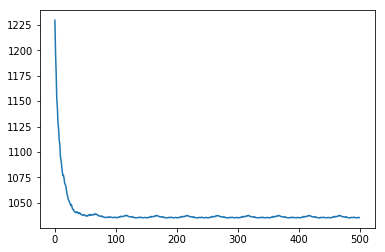

<TensorType(float64, matrix)>

In [82]:
# Discrete Hidden Markov Model (HMM) in Theano using gradient descent.
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import pymc as pm

def random_normalized(d1, d2):
    x = np.random.random((d1, d2))
    return x / x.sum(axis=1, keepdims=True)


class HMM(pm.Categorical):
    def __init__(self, M, X, learning_rate=0.001, max_iter=10, V=None, p_cost=1.0, print_period=10):
        self.M = M # number of hidden states
       # train the HMM model using stochastic gradient descent

        # determine V, the vocabulary size
        # assume observables are already integers from 0..V-1
        # X is a jagged array of observed sequences
        if V is None:
            V = max(max(x) for x in X) + 1
        N = len(X)
        print("number of train samples:", N)

        pi0 = np.ones(self.M) / self.M # initial state distribution
        A0 = random_normalized(self.M, self.M) # state transition matrix
        B0 = random_normalized(self.M, V) # output distribution

        thx, cost = self.set(pi0, A0, B0)

        pi_update = self.pi - learning_rate*T.grad(cost, self.pi)
        pi_update = pi_update / pi_update.sum()

        A_update = self.A - learning_rate*T.grad(cost, self.A)
        A_update = A_update / A_update.sum(axis=1).dimshuffle(0, 'x')

        B_update = self.B - learning_rate*T.grad(cost, self.B)
        B_update = B_update / B_update.sum(axis=1).dimshuffle(0, 'x')

        updates = [
            (self.pi, pi_update),
            (self.A, A_update),
            (self.B, B_update),
        ]

        train_op = theano.function(
            inputs=[thx],
            updates=updates,
            allow_input_downcast=True,
        )

        # self.cost_op = theano.function(
        #     inputs=[thx],
        #     outputs=cost,
        #     allow_input_downcast=True,
        # )

        costs = []
        for it in range(max_iter):
            if it % print_period == 0:
                print("it:", it)
            
            for n in range(N):
                # print "about to get the cost"
                # this would of course be much faster if we didn't do this on
                # every iteration of the loop
                c = self.get_cost_multi(X, p_cost).sum()
                costs.append(c)
                train_op(X[n])

        print("A:", self.A.get_value())
        print("B:", self.B.get_value())
        print("pi:", self.pi.get_value())
        print("len(costs):", len(costs))
    
        plt.plot(costs)
        plt.show()

    def get_cost(self, x):
        # returns log P(x | model)
        # using the forward part of the forward-backward algorithm
        return self.cost_op(x)

    def log_likelihood(self, x):
        return -self.cost_op(x)

    def get_cost_multi(self, X, p_cost=1.0):
        P = np.random.random(len(X))
        return np.array([self.get_cost(x) for x, p in zip(X, P) if p < p_cost])

    def set(self, pi, A, B):
        self.pi = theano.shared(pi)
        self.A = theano.shared(A)
        self.B = theano.shared(B)

        # define cost
        thx = T.ivector('thx')
        def recurrence(t, old_a, x):
            a = old_a.dot(self.A) * self.B[:, x[t]]
            s = a.sum()
            return (a / s), s

        [alpha, scale], _ = theano.scan(
            fn=recurrence,
            sequences=T.arange(1, thx.shape[0]),
            outputs_info=[self.pi*self.B[:,thx[0]], None],
            n_steps=thx.shape[0]-1,
            non_sequences=thx
        )

        cost = -T.log(scale).sum()
        self.cost_op = theano.function(
            inputs=[thx],
            outputs=cost,
            allow_input_downcast=True,
        )
        return thx, cost


hmm = HMM(2, X)


In [85]:
hmm.A

<TensorType(float64, matrix)>